In [1]:
import sys, os

import random
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nilmtk

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import adinilm.functions as F
from adinilm.enumerations import *
from adinilm.objs import DatasetProfile, ProfileHandler, NormalizationHandler
from adinilm.utils import paths_manager as pathsman
from adinilm.io import NilmtkSubsectionExtractor

In [3]:
SAVE_PROFILE = True

In [30]:
## Variable declaration for dataset
UKDALE_BUILDING = 1
UKDALE_START_TIME = "2015-01-01"
# END_TIME = "2015-01-15"
UKDALE_END_TIME = "2015-12-31"

FRIDGE_FREEZER = "fridge"
KETTLE = "kettle"
DISHWASHER = "dish washer"
MICROWAVE = "microwave"
WASHER_DRYER = "washer dryer"

applist = [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE]

In [31]:
info = {
        "subsection" : {
                "building" : UKDALE_BUILDING,
                "start_time" : UKDALE_START_TIME,
                "end_time": UKDALE_END_TIME
        },
        "preprocessing" : {
                "sampling" : {
                        "sample_period" : 6,
                        "resample" : True
                },
                "normalization" : {
                        "mode" : "minmax",
                        "scope" : "local"
                }
        },
        "appliances" : [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE],
        "appliance_data" : {
                FRIDGE_FREEZER : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                WASHER_DRYER : {               
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                KETTLE : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                DISHWASHER : {
                        "window" : 10,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                MICROWAVE : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                }
        }
}

In [32]:
ext = NilmtkSubsectionExtractor(dataset_path=pathsman.UKDALE_H5_PATH, params=info)


c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


In [33]:
ext.df.head(6)

,power_series,on_power_threshold,activations
fridge,2015-01-01 00:00:00+00:00 0.0 2015-01-01 00...,50.0,"[[0.0, 0.0, 103.0, 100.0, 97.0, 97.0, 95.0, 94..."
washer dryer,2015-01-01 00:00:00+00:00 0.0 2015-01-01 00...,20.0,"[[10.0, 10.0, 103.0, 103.0, 10.0, 10.0, 10.0, ..."
kettle,2015-01-01 00:00:00+00:00 1.0 2015-01-01 00...,10.0,"[[1.0, 1.0, 565.0, 2347.0, 2350.0, 2365.0, 238..."
dish washer,2015-01-01 00:00:00+00:00 1.0 2015-01-01 00...,10.0,"[[1.0, 1.0, 24.0, 23.0, 24.0, 24.0, 24.0, 6.0,..."
microwave,2015-01-01 00:00:00+00:00 1.0 2015-01-01 00...,200.0,"[[1.0, 1.0, 1632.0, 1623.0, 1619.0, 1612.0, 16..."
site meter,2015-01-01 00:00:00+00:00 139.301666 2015-0...,NaN,NaN


In [34]:
FS = 1/6          # 1 Hz
DUR = 600       # 512 sec

In [35]:
SAMPLE_LENGTH = int(DUR * FS)

In [36]:
def quantile_filter_2(data, sequence_length, p=50):
    new_mains = F.scan_sequences(data=data, mode="odd_window", seq_len=sequence_length)
    new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
    return new_mains

In [37]:
# utils

def match_timeframes(series):
        # Determine first and last timestamps
        start_tfs = []
        end_tfs = []
        for tf in series:
                index = tf.index
                start_tfs.append(index[0])
                end_tfs.append(index[-1])
        uniform_start_tf = max(start_tfs)
        uniform_end_tf = min(end_tfs)

        series_c = series.copy()
        for idx, tf in enumerate(series):
                series_c[idx] = tf[uniform_start_tf:uniform_end_tf]

        return series_c

In [38]:
class SubmeterDataframeFormatter:

        def __init__(self, applist: list):
                self.applist = applist

        def format(self, data : pd.DataFrame, *args, **kwargs) -> np.ndarray:
                finder = kwargs.get() if "finder" in kwargs else "power_series"
                data = data.loc[self.applist, finder]

                data = match_timeframes(data)
                p = [np.array(r) for r in data]

                data = np.array(p)
                data[np.isnan(data)] = 0
                return data.T

        def __call__(self, data, *args, **kwargs):
                return self.format(data, *args, **kwargs)

In [39]:
class SequenceToArrayFormatter:

        def __init__(self, info: list):
                self.info = info
        
        def format(self, data : pd.DataFrame, *args, **kwargs) -> np.ndarray:
                finder = kwargs.get() if "finder" in kwargs else "power_series"
                data = data.loc[self.info["appliances"], finder]
                p = [np.array(r) for r in data]

                data = np.array(p)
                data[np.isnan(data)] = 0
                return data.T
        
        def __call__(self, data, *args, **kwargs):
                return self.format(data, *args, **kwargs)

In [40]:
class QuantileFilterApplier:

        def __init__(self, info, p=50):
                self.info = info
                self.p = p
        
        def filter(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[:,i] = quantile_filter_2(data[:,i], self.info["appliance_data"][app]["window"], p=self.p)
                return data_c

        def __call__(self, data, *args, **kwargs):
                return self.filter(data, *args, **kwargs)

In [41]:
class AdaptiveMinMaxScaling:
    
        def __init__(self, info):
                self.info = info

        def normalize(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[:,i] = F.adaptive_minmax_scaling(data[:,i])
                
                return data_c

        def __call__(self, data, *args, **kwargs):
                return self.normalize(data, *args, **kwargs)


In [42]:
class OnPowerThresholdBinarizer:
        def __init__(self, info):
                self.info = info
        
        def binarize(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[:,i] = F.binarization(data[:,i], mode="threshold", threshold=self.info["appliance_data"][app]["on_power_threshold"])
                return data_c
        
        def __call__(self, data, *args, **kwargs):
                return self.binarize(data, *args, **kwargs)

In [43]:
class SubmeterMixer:

        def __init__(self, *args, **kwargs):
                self.ax = kwargs.get("axis") if "axis" in kwargs else 1

        def mix(self, data : np.ndarray, *args, **kwargs):
                return data.sum(axis=self.ax)

        def __call__(self, data, *args, **kwargs):
                return self.mix(data, *args, **kwargs)

In [44]:
class NoisedInput:

        def noise(self, data, *args, **kwargs):
                _denoise = quantile_filter_2(data, 10, 50)
                data = data - np.percentile(data, 1)
                data = np.where(data < _denoise, _denoise, data)
                return quantile_filter_2(data, 10, 50)

        def __call__(self, data, *args, **kwargs):
                return self.noise(data, *args, **kwargs)

In [45]:
formatter = SequenceToArrayFormatter(ext.params)
filterer = QuantileFilterApplier(ext.params)
normalizer = AdaptiveMinMaxScaling(ext.params)
binarizer = OnPowerThresholdBinarizer(ext.params)
mixer = SubmeterMixer(axis=1)
noiser = NoisedInput()

In [46]:
# Pipeline Workflow
data = formatter(ext.df)
data_i = mixer(data)
data_i_den = quantile_filter_2(data_i, 10, p=50)
data_i_den = F.adaptive_minmax_scaling(data_i_den)
data_i_n = noiser(data_i)
data_i_n = F.adaptive_minmax_scaling(data_i_n)
data = filterer(data)
data_p = normalizer(data)
data_s = binarizer(data)

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_60056\361044578.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")


In [47]:
data_s

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [48]:
data_p[np.isnan(data_p)] = 0

In [49]:
data_p

array([[0.        , 0.        , 0.00041339, 0.00041   , 0.00063492],
       [0.        , 0.        , 0.00041339, 0.00041   , 0.00063492],
       [0.        , 0.        , 0.00041339, 0.00041   , 0.00063492],
       ...,
       [0.        , 0.        , 0.00041339, 0.        , 0.00063492],
       [0.        , 0.        , 0.00041339, 0.        , 0.00063492],
       [0.        , 0.        , 0.00041339, 0.        , 0.00063492]],
      dtype=float32)

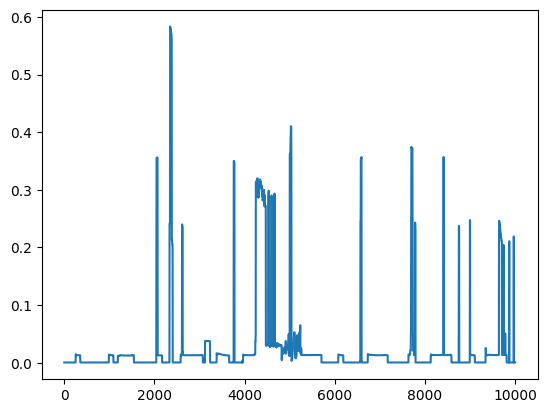

In [50]:
plt.plot(data_i_n[60000:70000])

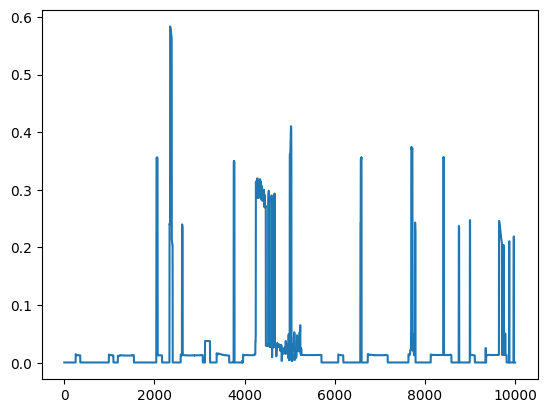

In [51]:
plt.plot(data_i_den[60000:70000])

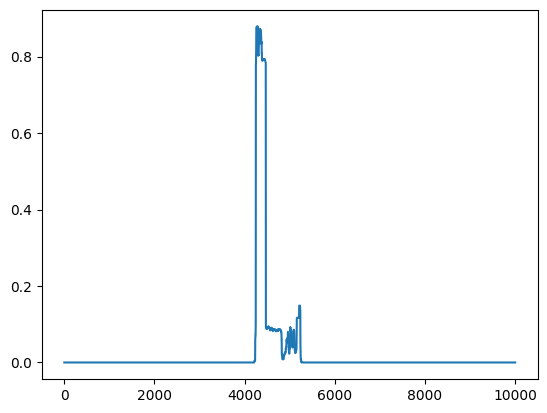

In [52]:
plt.plot(data_p[60000:70000,1])

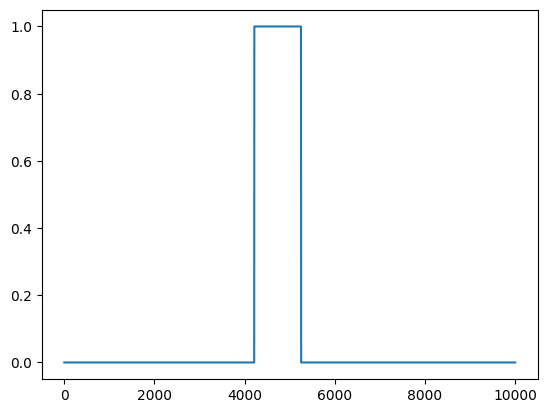

In [53]:
plt.plot(data_s[60000:70000,1])

In [54]:
if SAVE_PROFILE:
        ProfileHandler.mkdir(pathsman.PROFILES_DIR, exist_ok=True)
        prof = DatasetProfile(parent_dir=pathsman.PROFILES_DIR,
                        handler=NILMProjects.UNETNILM.value,
                        dataset_name="ukdale",
                        metadata=info,
                        mode="w")
        ret = ProfileHandler.write(data_i_den, data_i_n, data_p, data_s, profile=prof, subdir="training")
        print(ret)

Full path: C:\Users\MTinaco\Dev\Solutions\cos-algo-nilm\profiles\unetnilm_ukdale_20240820_204947
                
